In [16]:
import random
import numpy as np
import matplotlib
import time
from numba import jit
import multiprocessing as mp
from matplotlib import pyplot as plt

# Demand function

In [17]:
@jit(nopython=True)
def demand(p1, p2):
    if p1 < p2:
        d = 1 - p1
    elif p1 == p2:
        d = 0.5 * (1 - p1)
    else:
        d = 0
    return d

# Profit function

In [18]:
@jit(nopython=True)
def profit(p1, p2):
    return (p1 * demand(p1, p2))

In [19]:
P = np.array([0, 1/6, 2/6, 3/6, 4/6, 5/6, 1]) # price array

# Epsilon greedy

In [20]:
@jit(nopython=True)
def epsilon_greedy(expected_profit, epsilon, uniform, price_grid: np.ndarray) -> int: 
    N = len(price_grid)

    # Draw action 
    if uniform < epsilon:
        price_index = np.random.choice(N)
    else:
        price_index = np.argmax(expected_profit)
    return price_index

# Probability array

In [21]:
# Probability array for opponents choice
@jit(nopython=True)
def prob_array(Qtable, price_grid, price_index_i):
    K = len(price_grid)
    prob_matrix = np.zeros((K, K))

    # [Anders] a faster way of doing the below is 
    # prob_matrix = Qtable / np.sum(Qtable, axis=1)[:, None]

    prob_matrix[price_index_i] = Qtable[price_index_i, :] / np.sum(Qtable[price_index_i, :])

    return prob_matrix


# Expected profit

In [23]:
@jit(nopython=True)
def expected_profit_sequential(idx_state:int, price_grid, prob_opponent, discount_factor: float): 
    K = len(price_grid)
    expected_profit = np.zeros(K)

    # verify that the prob_opponent makes sense 
    assert prob_opponent.shape == (K,K)
    #assert np.isclose(prob_opponent.sum(axis=1) , 1.0).all()

    for i in range(K): # my price 
        profit_now = profit(price_grid[i], price_grid[idx_state]) # opponent cannot update price yet 
        profit_next = np.zeros(K)
        for j in range(K): 
            profit_next[j] = profit(price_grid[i], price_grid[j]) # I cannot update next period 

        this_prob_opponent = prob_opponent[i,:] # my opponent will respond to my price with this probability vector 
        expected_profit[i] = profit_now + discount_factor * np.sum(profit_next * this_prob_opponent)
    
    return expected_profit 
        

# Fictitious Play

In [24]:
@jit(nopython=True)
def FictitiousPlay(price_grid, periods, discount_factor, theta):
    K = len(price_grid)
    epsilons = (1 - theta)**np.arange(periods + 1)
    uniforms = np.random.uniform(0, 1, (periods + 1, 2))
    
    # Initialize count and profit arrays
    count_i = np.zeros((K, K))
    count_opponent = np.zeros((K, K))

    prob_opponent = np.zeros((K, K))

    # above, you have "i" and "j", but now you have "1" and "2"? 
    profit_1 = np.zeros(int(periods))
    profit_2 = np.zeros(int(periods))

    avg_profit = np.zeros(periods)

    # Period 0 
    price_index_opponent = np.random.choice(K) 
    price_index_i = np.random.choice(K) 
    #print("T = 0")
    #print("price_index_i:", price_index_i)
    #print("price_index_opponent:", price_index_opponent)

    # if you simulate these choices for period t=0, why not compute 
    # the profits as well? 

    for t in range(1, periods + 1):
        #print("T = ", t)
        # Update count_array based on the recent action of the opponent
        # [Anders] why are you updating the full column? Shouldn't it 
        # just be 
        # Qtable_i[price_index_i, price_index_j] += 1
        # With the current specification, I'd think it might make more 
        # sense to just store the counts of the opponent's actions in 
        # a 1D array, since the player's own actions are irrelevant.
        #print("price_index_i:", price_index_i)
        #print("price_index_opponent:", price_index_opponent)
        if t % 2 == 0:
            # player 2 is the responder
            player_index = 1
            opponent_index = 0
        else:
            # player 1 is the responder
            player_index = 0
            opponent_index = 1
        
        count_i[price_index_i, price_index_opponent] += 1
        #print("count_i:", count_i)

        # Calculate the probability vector for the opponents actions 
        prob_opponent = prob_array(count_i, price_grid, price_index_i)
        #print("prob_opponent:", prob_opponent)

        # Calculate the expected profit for each action
        expected_profit_array = expected_profit_sequential(price_index_opponent, price_grid, prob_opponent, discount_factor)
        #print("expected_profit_array:", expected_profit_array)

        # Choosing the action with the largest expected profit
        price_index_i = epsilon_greedy(expected_profit_array, epsilons[t], uniforms[t, opponent_index], price_grid)
        #print("price_index_i:", price_index_i)

        # Calculate the profit for player i and j
        # [Anders] Here, you correctly compute (and later store) the profits for each 
        # player and for all periods, also the ones where they are not acting. 
        # But when the player makes the action, the expected profit array does not 
        # take this into account.
        profit_opponent = profit(price_grid[price_index_opponent], price_grid[price_index_i])
        profit_i_current_period = profit(price_grid[price_index_i], price_grid[price_index_opponent])
        #print("profit_i_current_period:", profit_i_current_period)
        #print("profit_opponent:", profit_opponent)

        # Average profit
        avg_profit[t-1] = (profit_i_current_period + profit_opponent) / 2

        # Update the individual profit arrays
        if t % 2 == 0:
            profit_1[t-1] = profit_opponent
            profit_2[t-1] = profit_i_current_period
        else:
            profit_1[t-1] = profit_i_current_period
            profit_2[t-1] = profit_opponent

        # Switch player for next period
        count_i, count_opponent = count_opponent, count_i
        price_index_opponent = price_index_i
    
    return avg_profit, profit_1, profit_2

In [25]:
@jit(nopython=True)
def Simulations(simulations, price_grid, periods, discount_factor, theta):
    # Initialize profit and average profit arrays
    total_profit_sim = np.zeros((simulations, periods))
    profit_1_sim = np.zeros((simulations, periods))
    profit_2_sim = np.zeros((simulations, periods))
    avg_profit_1 = np.zeros(simulations)
    avg_profit_2 = np.zeros(simulations)

    for i in range(simulations):
        total_profit_array, profit_1_array, profit_2_array = FictitiousPlay(price_grid, periods, discount_factor, theta)
        total_profit_sim[i] = total_profit_array
        profit_1_sim[i] = profit_1_array
        profit_2_sim[i] = profit_2_array
        avg_profit_1[i] = np.mean(profit_1_array[-1000:]) # mean of the last 1000 periods # [Anders] Obvious, but why 1000? And why not all periods? 
        avg_profit_2[i] = np.mean(profit_2_array[-1000:]) # mean of the last 1000 periods

    return total_profit_sim, avg_profit_1, avg_profit_2, profit_1_sim, profit_2_sim

# Time calculation for 1000 simulations

In [45]:
N_sim = 1000

In [46]:
# ensure that numba is compiled 
_ = Simulations(10, P, 10, 0.95, 0.0000276306)

In [47]:
# time 10 calls to the function
start = time.time()
Simulations(N_sim, P, 10, 0.95, 0.0000276306)
end = time.time()

time_per_period = (end - start) / 10

In [48]:
N_sim = 1000
N_periods = 500000
print(f'Starting run: expect  {time_per_period * N_periods / 60. : 5.2f} min')

start_time  = time.time()
total_profit_plot, avg_profit_1_plot, avg_profit_2_plot, profit_total_1, profit_total_2 = Simulations(N_sim, P, N_periods, 0.95, 0.0000276306)
end_time = time.time()

print(f'Running time: {(end_time-start_time)/60.:.2f} min')

Starting run: expect   7.54 min
Running time: 7.14 min


# Profitability

In [49]:
samlet_prof = total_profit_plot.mean(0)
window_size = 1000
  
i = 0
# Initialize an empty list to store moving averages
moving_averages = []
# Loop through the array t o
#consider every window of size 1000
while i < len(samlet_prof) - window_size + 1:
  
    # Calculate the average of current window
    window_average = np.sum(samlet_prof[i:i+window_size]) / window_size
      
    # Store the average of current
    # window in moving average list
    moving_averages.append(window_average)
      
    # Shift window to right by one position
    i += 1

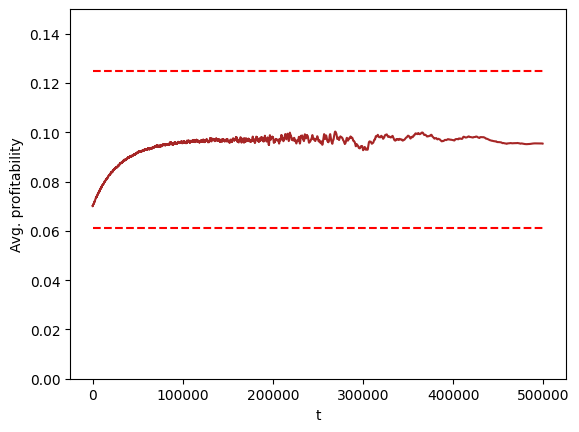

In [50]:
plt.plot(moving_averages, color='#a62626', label="Average profitability")
plt.xlabel('t')
plt.ylabel('Avg. profitability')
plt.ylim(0.00, 0.15)
plt.hlines(y=0.0611, xmin=0, xmax=500000, colors='red', linestyles='--')
plt.hlines(y=0.125, xmin=0, xmax=500000, colors='red', linestyles='--')
plt.show()

# Optimality

In [51]:
def delta_prof(avg_array_1, avg_array_2, sim):
    # What is delta? 
    # "avg_array": avg. of what? 
    together_array = np.vstack((avg_array_1, avg_array_2))
    together_array_mean = np.mean(together_array, axis=0)
    delta_1 = np.zeros(len(together_array_mean))
    for i in range(sim):
        delta_1[i] = ((together_array_mean[i]) / (0.125))
    return delta_1

In [52]:
#dividing delta into intervals
# what is delta and why divide it into intervals?
def delta_div(delta_arr):
    new_delt = np.zeros(5) # why 5? 
    for i in range(len(delta_arr)):
        if delta_arr[i] <=1 and delta_arr[i] > 0.9: 
        #if delta_arr[i] == 1 :
            new_delt[4]+=1
        elif delta_arr[i] <=0.9 and delta_arr[i] > 0.8:
            new_delt[3]+=1
        elif delta_arr[i] <=0.8 and delta_arr[i] > 0.7:
            new_delt[2]+=1
        elif delta_arr[i] <= 0.7 and delta_arr[i] > 0.6:
            new_delt[1]+=1
        else:
            new_delt[0] +=1
    return new_delt

In [55]:
delta_1 = delta_prof(avg_profit_1_plot, avg_profit_2_plot, 1000)

delta_2 = delta_div(delta_1)

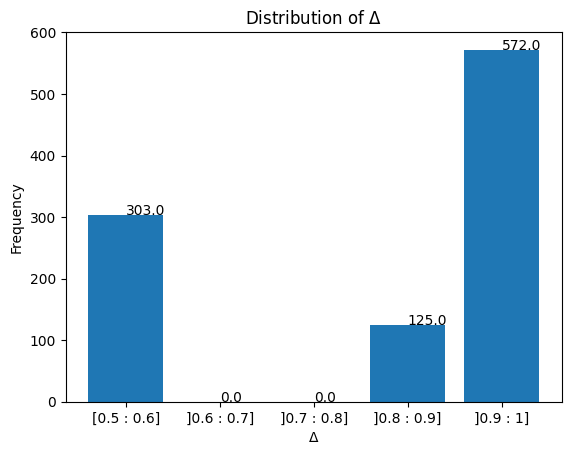

In [56]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

langs = ['[0.5 : 0.6]', ']0.6 : 0.7]', ']0.7 : 0.8]', ']0.8 : 0.9]', ']0.9 : 1]']

y_pos = np.arange(len(langs))

plt.title("Distribution of $\Delta$")
# Create bars
plt.bar(y_pos, delta_2)

addlabels(langs, delta_2 )
# Create names on the x-axis
plt.xticks(y_pos, langs)
plt.xlabel("$\Delta$")
plt.ylabel("Frequency")
#make label
label = [delta_2]
# Show graphic
plt.show()

# Heatmap

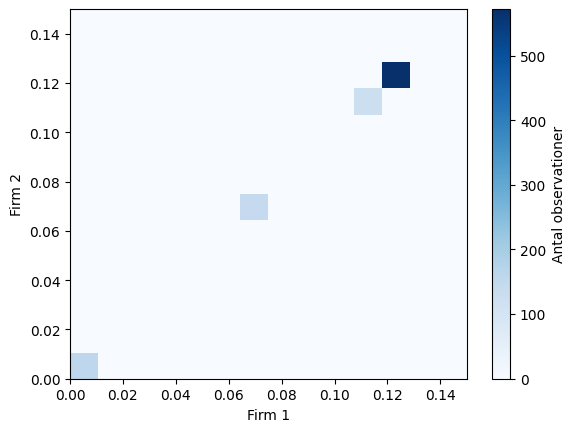

In [57]:
x_bins = np.linspace(0, 0.15, 15)
y_bins = np.linspace(0, 0.15, 15)

heatmap, xedges, yedges = np.histogram2d(avg_profit_1_plot, avg_profit_2_plot, bins=[x_bins, y_bins])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='Blues', aspect='auto')
cb = plt.colorbar()
cb.set_label('Antal observationer')
plt.xlabel("Firm 1")
plt.ylabel("Firm 2")

plt.show()